In this project, we explore non-linear models through the Multilayer Perceptron (MLP) and the
Convolutional Neural Network (CNN) on classification problems. We implement the MLP from
scratch as well as functions for forward pass and backward propagation. For the CNN we use
PyTorch to implement both simple CNNs and Robust Models using techniques seen in class. We also
experiment with the ResNet50 model and tune it to our data. Our first data set was FashionMNIST,
which is a collection of 70,000 28x28 gray scale images of 10 kinds of clothing (10 classes). The
second, CIFAR-10 contains 10 classes for different animals and machines with 3x32x32 images in
RGB.

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader
import seaborn as sns
%matplotlib inline

Load Fashion MNIST

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


In [17]:
np.unique(training_data.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
       dtype=int64))

In [18]:
np.unique(test_data.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       dtype=int64))

We see the training and test data has a uniform distribution

Method for One Hot Encoding

In [19]:
def one_hot_encoding(a, classes=10):
    b = np.zeros((a.size, classes ) )
    b[np.arange(a.size), a] = 1
    return b

We want to do everything from scratch so convert data into numpy arrays.

In [20]:
#Create training set for x and ys
x_train_fash, y_train_fash = training_data.data, training_data.targets
y_train_fash = np.array(y_train_fash)
x_train_fash = np.array(x_train_fash)
x_train_fash = x_train_fash.reshape(-1, 784)
x_train_fash = (x_train_fash/255).astype('float64')
y_train_fash = y_train_fash.reshape(1, -1)
y_train_fash = one_hot_encoding(y_train_fash)
y_train_fash = y_train_fash.reshape(-1, 10)

In [21]:
#Create testing set for x and ys
x_test_fash, y_test_fash = test_data.data, test_data.targets
y_test_fash = np.array(y_test_fash)
x_test_fash = np.array(x_test_fash)
x_test_fash = x_test_fash.reshape(-1, 784)
x_test_fash = (x_test_fash/255).astype('float64')

y_test_fash = y_test_fash.reshape(1, -1)
y_test_fash = one_hot_encoding(y_test_fash)
y_test_fash = y_test_fash.reshape(-1, 10)

In [ ]:
#More useful functions we will need
def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def cross_entropy_loss(y, yHat):
    epsilon = 1e-5
    return -np.mean(np.sum(y * np.log(yHat + epsilon), axis=1))

def accuracy(yhat, y):
    return np.mean(yhat == y)

We use strategy design pattern for our weights and regualrization

In [ ]:
from numpy import sqrt
from abc import abstractmethod, ABC

#Abstract Strategy
class InitializeWeights(ABC):
    @abstractmethod
    def create_weights(self, nodes : list):
        pass
#Concrete Strategy#
#Weights as standard normals
class NormalWeights(InitializeWeights):
    def create_weights(self, nodes):
        weights = []
        bias = []
        for i in range(1, len(nodes) ):
            weights.append( np.random.normal(0, 1, size= (nodes[i-1],nodes[i])  ) )
            bias.append( np.zeros( ( 1,nodes[i])  ) )
        return weights, bias
#Weights as zeros
class ZeroWeights(InitializeWeights):
    def create_weights(self, nodes):
        weights = []
        bias = []
        for i in range(1, len(nodes) ):
            weights.append( np.zeros( (nodes[i-1],nodes[i])  ) )
            bias.append( np.zeros( ( 1,nodes[i])  ) )
        return weights, bias
#Uniform distribution for weights
class UniformWeights(InitializeWeights):
    def create_weights(self, nodes):
        weights = []
        bias = []
        for i in range(1, len(nodes) ):
            weights.append( np.random.uniform( -1 , 1, size=(nodes[i-1], nodes[i]) ))
            bias.append( np.zeros( ( 1,nodes[i])  ) )
        return weights, bias
#Xavier
class XavierWeights(InitializeWeights):
    def create_weights(self, nodes):
        weights = []
        bias = []
        for i in range(1, len(nodes) ):
            weights.append( np.random.uniform( -1/sqrt(nodes[i-1]) , 1/sqrt(nodes[i-1]) , size=(nodes[i-1], nodes[i]) ))
            bias.append( np.zeros( ( 1,nodes[i])  ) )
        return weights, bias
#Kaiming
class KaimingWeights(InitializeWeights):
    def create_weights(self, nodes):
        weights = []
        bias = []
        for i in range(1, len(nodes) ):
            weights.append( np.random.normal( 0 , 2/nodes[i-1] , size=(nodes[i-1], nodes[i]) ))
            bias.append( np.zeros( ( 1,nodes[i])  ) )
        return weights, bias

Strategy design pattern for activations

In [ ]:
#Abstract activation function
#Note all derivatives take the activation function as input not x for some simplification.
class Activation(ABC):
    @abstractmethod
    def forward(self, s):
        pass
    @abstractmethod
    def derivative(self, s):
        pass

class ReLUActivation(Activation):
    def forward(self, s):
        return np.maximum(0, s)
    def derivative(self, s):
        return np.where(s>0, 1, 0)

class SigmoidActivation(Activation):
    def forward(self, s):
        return np.exp(s) / (1 + np.exp(s))
    def derivative(self, s):
        return s*(1-s)

class TanHActivation(Activation):
    def forward(self, s):
        return np.tanh(s)
    def derivative(self, s):
        return 1- np.square(s)

Strategy design pattern for regularization.

In [ ]:
class Regularize(ABC):
    def __init__(self, c):
        self.c = c
    @abstractmethod
    def regularize(self, w, c):
        pass

class l1Regular(Regularize):
    def regularize(self, w):
        return self.c

class l2Regular(Regularize):
    def regularize(self, w):
        return self.c*w

In [ ]:
#Model of our MLP
#With methods fit and predict we also implement momentum for our MLP
class MLP:
    def __init__(self, lr= 0.005 , nodes = [784, 128, 10], beta_momentum=0.9, batchsize = 128, initialWeightStrategy : InitializeWeights = NormalWeights(),
                 activation = SigmoidActivation(), regularization=None ):
        self.lr = lr
        self.nodes = nodes
        self.layers = len(self.nodes)-1
        self.weights = []
        self.bias = []
        self.beta = beta_momentum
        self.batchsize = batchsize
        self.weights, self.bias = initialWeightStrategy.create_weights(self.nodes)
        self.activation = activation
        self.w_run_avg = [0 for w in self.weights]
        self.b_run_avg = [0 for b in self.bias]
        self.cost_history = []
        self.epoch_history = []
        self.regularization = regularization

    def fit(self, x_train, y_train, epochs=20, verbose=False):
        for epoch in range(epochs):
            for batch in self.loop_minibatches(x_train,y_train):
                x,y = batch
                N,D = x.shape
                #FEED FORWARD
                activations = [x]
                a = x
                for i,w in enumerate(self.weights):
                    z = (a @ w + self.bias[i])
                    if i < len(self.weights) - 1:
                        a = self.activation.forward(z)
                    else:
                        a = softmax(z)
                    activations.append(a)
                #BACK PROP
                res = a
                delta = res - y
                for i in range(self.layers, 0, -1):
                    a = activations[i]
                    a_prev = activations[i-1]
                    delta = delta
                    if i != self.layers:
                        delta = self.activation.derivative(a) * delta
                    dw = a_prev.T @ delta / N
                    db = np.sum(delta , axis=0, keepdims=True)
                    if self.regularization:
                        dw+= self.regularization.regularize(self.weights[i-1])
                        pass
                    self.w_run_avg[i-1] = self.beta * self.w_run_avg[i-1] + ((1 - self.beta ) * dw)
                    self.b_run_avg[i-1] = self.beta * self.b_run_avg[i-1] + ((1 - self.beta ) * db)
                    self.weights[i-1] -= self.lr * self.w_run_avg[i-1]
                    self.bias[i-1] -= self.lr * self.b_run_avg[i-1]
                    delta = delta @ self.weights[i-1].T
            loss = cross_entropy_loss(y, res)
            self.cost_history.append(loss)
            self.epoch_history.append(epoch)
            if verbose:
                print(f"Epoch : {epoch+1} | Loss : {loss}")


    def predict(self, x):
        a = x
        for i,w in enumerate(self.weights):
            z = (a @ w + self.bias[i])
            if i < len(self.weights) - 1:
                a = self.activation.forward(z)
            else:
                a = softmax(z)
        return a

    def loop_minibatches(self, x, y, shuffle=True):
        if shuffle:
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
        for start_i in range(0, x.shape[0] - self.batchsize + 1, self.batchsize):
            if shuffle:
                piece = indices[start_i:start_i + self.batchsize]
            else:
                piece = slice(start_i, start_i + self.batchsize)
            yield x[piece], y[piece]

# Experiments:

### 1. Comparing Training Curves To Different Weight Init Methods

Epoch : 1 | Loss : 2.3008989639123176
Epoch : 2 | Loss : 2.3029589783179496
Epoch : 3 | Loss : 2.3037067441217607
Epoch : 4 | Loss : 2.3023604670600397
Epoch : 5 | Loss : 2.305391221656749
Epoch : 6 | Loss : 2.3001876377585644
Epoch : 7 | Loss : 2.303782114404063
Epoch : 8 | Loss : 2.2965773335193265
Epoch : 9 | Loss : 2.3043639194969034
Epoch : 10 | Loss : 2.302651007091361
Epoch : 11 | Loss : 2.3063668003823463
Epoch : 12 | Loss : 2.3024249074377576
Epoch : 13 | Loss : 2.301260677128708
Epoch : 14 | Loss : 2.3023977779448885
Epoch : 15 | Loss : 2.3004833830925326
Epoch : 16 | Loss : 2.304571560364007
Epoch : 17 | Loss : 2.304521449346053
Epoch : 18 | Loss : 2.3022536375649203
Epoch : 19 | Loss : 2.30407097241716
Epoch : 20 | Loss : 2.300871436729707
Epoch : 21 | Loss : 2.3010020068435493
Epoch : 22 | Loss : 2.3023842500267175
Epoch : 23 | Loss : 2.303334963868063
Epoch : 24 | Loss : 2.3033252985133075
Epoch : 25 | Loss : 2.300606004359107
Epoch : 26 | Loss : 2.301183120597777
Epoch :

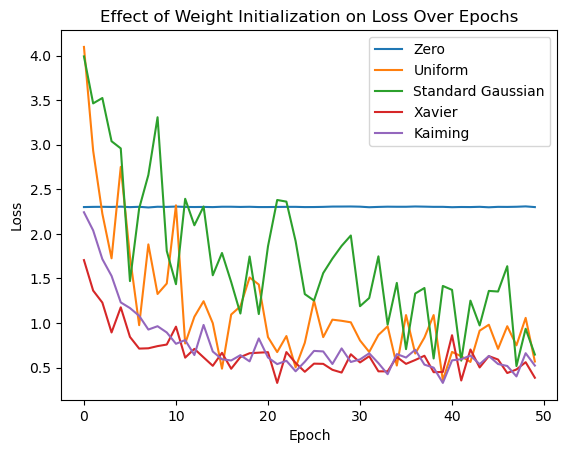

In [466]:
zeroMLP = MLP(lr = 0.001, nodes = [784, 128, 10], beta_momentum = 0.9, initialWeightStrategy=ZeroWeights(), activation = ReLUActivation(), batchsize=64)
uniformMLP = MLP(lr = 0.001, nodes = [784, 128, 10], beta_momentum = 0.9, initialWeightStrategy = UniformWeights(), activation = ReLUActivation(), batchsize = 64)
gaussianMLP = MLP(lr = 0.001, nodes = [784, 128, 10], beta_momentum = 0.9, initialWeightStrategy = NormalWeights(), activation = ReLUActivation(), batchsize = 64)
xavierMLP = MLP(lr = 0.001, nodes = [784, 128, 10], beta_momentum = 0.9, initialWeightStrategy = XavierWeights(), activation = ReLUActivation(), batchsize = 64)
kaimingMLP = MLP(lr = 0.001, nodes = [784, 128, 10], beta_momentum = 0.9, initialWeightStrategy = KaimingWeights(), activation = ReLUActivation(), batchsize = 64)

models = [zeroMLP, uniformMLP, gaussianMLP, xavierMLP, kaimingMLP]
names = ["Zero", "Uniform", "Standard Gaussian", "Xavier", "Kaiming"]


for model, name in zip(models, names):
    model.fit(x_train_fash, y_train_fash, epochs=50, verbose=True)
    yhat = np.argmax(model.predict(x_test_fash), axis=1)
    yraw = np.argmax(y_test_fash, axis=1)
    model_accuracy = accuracy(yraw, yhat)
    print(f"Accuracy of {name} on TEST data is {model_accuracy}")
    plt.plot(model.epoch_history, model.cost_history, label=name)
plt.title("Effect of Weight Initialization on Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.savefig('weight_init_plot.png', bbox_inches='tight')
plt.show()

### 2. Three Different MLP Models

Epoch : 1 | Loss : 1.2808667453456115
Epoch : 2 | Loss : 0.9734974239153085
Epoch : 3 | Loss : 0.8214981169730262
Epoch : 4 | Loss : 1.043458984702002
Epoch : 5 | Loss : 0.7973911749480136
Epoch : 6 | Loss : 0.8370100629432028
Epoch : 7 | Loss : 0.6824849717052671
Epoch : 8 | Loss : 0.734152261485826
Epoch : 9 | Loss : 0.7101272600301615
Epoch : 10 | Loss : 0.5217765121650131
Epoch : 11 | Loss : 0.645582561633692
Epoch : 12 | Loss : 0.6336610223427983
Epoch : 13 | Loss : 0.5261689972254486
Epoch : 14 | Loss : 0.5655894810748618
Epoch : 15 | Loss : 0.6460024985981415
Epoch : 16 | Loss : 0.5639646444421473
Epoch : 17 | Loss : 0.6091375167065407
Epoch : 18 | Loss : 0.41134469241768434
Epoch : 19 | Loss : 0.4770001850291476
Epoch : 20 | Loss : 0.6622924110784228
Epoch : 21 | Loss : 0.8236282137776698
Epoch : 22 | Loss : 0.6487632010981488
Epoch : 23 | Loss : 0.6886062996711031
Epoch : 24 | Loss : 0.7802665034538272
Epoch : 25 | Loss : 0.4167526809576156
Epoch : 26 | Loss : 0.71409706355123

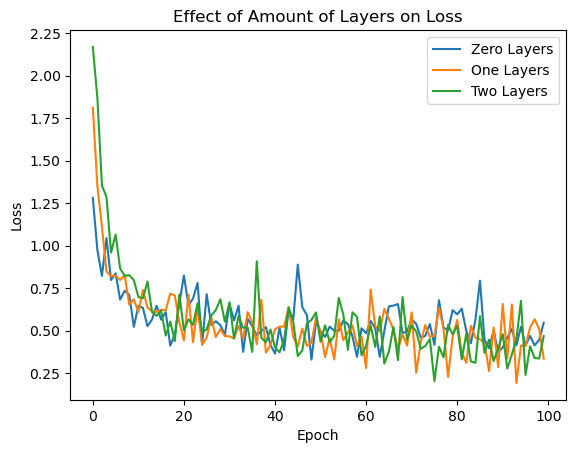

In [307]:
noLayersMLP = MLP(lr = 0.001, nodes = [784, 10], beta_momentum = 0.0, initialWeightStrategy=XavierWeights(), batchsize=64)
oneLayerMLP = MLP(lr = 0.001, nodes = [784, 128, 10], beta_momentum = 0.0, initialWeightStrategy = XavierWeights(), activation = ReLUActivation(), batchsize = 64)
twoLayersMLP = MLP(lr = 0.001, nodes = [784, 128, 128, 10], beta_momentum = 0.0, initialWeightStrategy = XavierWeights(), activation = ReLUActivation(), batchsize = 64)

models = [noLayersMLP, oneLayerMLP, twoLayersMLP]
names = ["Zero Layers", "One Layers", "Two Layers"]

for model, name in zip(models, names):
    model.fit(x_train_fash, y_train_fash, epochs=100, verbose=True)
    yhat = np.argmax(model.predict(x_test_fash), axis=1)
    yraw = np.argmax(y_test_fash, axis=1)
    model_accuracy = accuracy(yraw, yhat)
    print(f"Accuracy of {name} on TEST data is {model_accuracy}")
    plt.plot(model.epoch_history, model.cost_history, label=name)
plt.title("Effect of Amount of Layers on Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.savefig('depth_plot.png', bbox_inches='tight')
plt.show()

### 3. Different Activation Functions

Epoch : 1 | Loss : 2.8270042098788415
Epoch : 2 | Loss : 1.8397273680985742
Epoch : 3 | Loss : 1.2933269862164951
Epoch : 4 | Loss : 1.0189942400157384
Epoch : 5 | Loss : 1.4596779049390685
Epoch : 6 | Loss : 0.7885855331870645
Epoch : 7 | Loss : 0.8825706343467821
Epoch : 8 | Loss : 0.6152696683502864
Epoch : 9 | Loss : 0.7518795355159786
Epoch : 10 | Loss : 0.6809877605513728
Epoch : 11 | Loss : 0.8211467373023389
Epoch : 12 | Loss : 0.8651325101939804
Epoch : 13 | Loss : 0.7953146310114239
Epoch : 14 | Loss : 0.5940708133754498
Epoch : 15 | Loss : 0.6624984592274823
Epoch : 16 | Loss : 0.4311236345619435
Epoch : 17 | Loss : 0.4530177643989552
Epoch : 18 | Loss : 0.7455845384493305
Epoch : 19 | Loss : 0.8641890838912614
Epoch : 20 | Loss : 0.7286140420884114
Epoch : 21 | Loss : 0.5116346625322963
Epoch : 22 | Loss : 0.48981660575775277
Epoch : 23 | Loss : 0.6508439275938471
Epoch : 24 | Loss : 0.7810912918901219
Epoch : 25 | Loss : 0.6539494257986112
Epoch : 26 | Loss : 0.66071071583

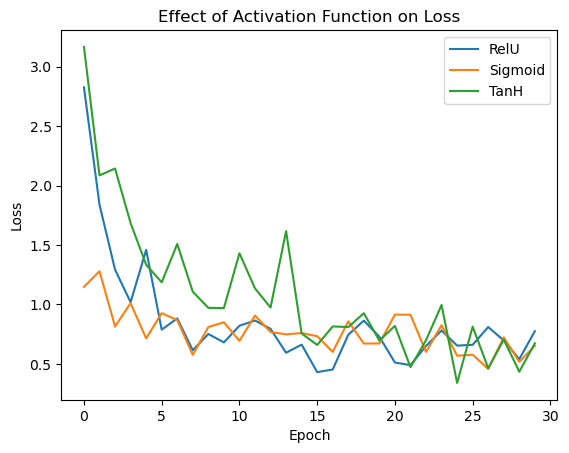

In [485]:
twoLayersSigMLP = MLP(lr = 0.005, nodes = [784, 128, 128, 10], beta_momentum = 0.9, initialWeightStrategy = NormalWeights(), activation = SigmoidActivation(), batchsize = 64)
twoLayersTanhMLP = MLP(lr = 0.005, nodes = [784, 128, 128, 10], beta_momentum = 0.9, initialWeightStrategy = NormalWeights(), activation = TanHActivation(), batchsize = 64)
twoLayersRelUMLP = MLP(lr = 0.005, nodes = [784, 128, 128, 10], beta_momentum = 0.9, initialWeightStrategy = NormalWeights(), activation = ReLUActivation(), batchsize = 64)

models = [twoLayersRelUMLP, twoLayersSigMLP, twoLayersTanhMLP]
names = ["RelU", "Sigmoid", "TanH"]

for model, name in zip(models, names):
    model.fit(x_train_fash, y_train_fash, epochs=30, verbose=True)
    yhat = np.argmax(model.predict(x_test_fash), axis=1)
    yraw = np.argmax(y_test_fash, axis=1)
    model_accuracy = accuracy(yraw, yhat)
    print(f"Accuracy of {name} on TEST data is {model_accuracy}")
    plt.plot(model.epoch_history, model.cost_history, label=name)
plt.title("Effect of Activation Function on Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('activation_plot.png', bbox_inches='tight')
plt.show()

### 4. Regularization

Epoch : 1 | Loss : 3.046173815328517
Epoch : 2 | Loss : 3.441101550568967
Epoch : 3 | Loss : 2.905199857236676
Epoch : 4 | Loss : 1.5072890531807461
Epoch : 5 | Loss : 1.466911022305719
Epoch : 6 | Loss : 0.6358916432644739
Epoch : 7 | Loss : 1.3224687558749042
Epoch : 8 | Loss : 1.0612708044915986
Epoch : 9 | Loss : 1.0961175452599579
Epoch : 10 | Loss : 0.6759871847925982
Epoch : 11 | Loss : 0.9203771963743432
Epoch : 12 | Loss : 0.7754925492396484
Epoch : 13 | Loss : 0.7607371357099453
Epoch : 14 | Loss : 0.7631027985208378
Epoch : 15 | Loss : 0.7311540356966167
Epoch : 16 | Loss : 0.44501079532538057
Epoch : 17 | Loss : 0.9933883342077993
Epoch : 18 | Loss : 0.8653221387898061
Epoch : 19 | Loss : 0.6407192238607902
Epoch : 20 | Loss : 0.4661438335882313
Epoch : 21 | Loss : 0.7637996388694472
Epoch : 22 | Loss : 0.6374517586681108
Epoch : 23 | Loss : 0.4660855489498199
Epoch : 24 | Loss : 0.49354104851480074
Epoch : 25 | Loss : 0.617741994427595
Epoch : 26 | Loss : 0.846466661613366

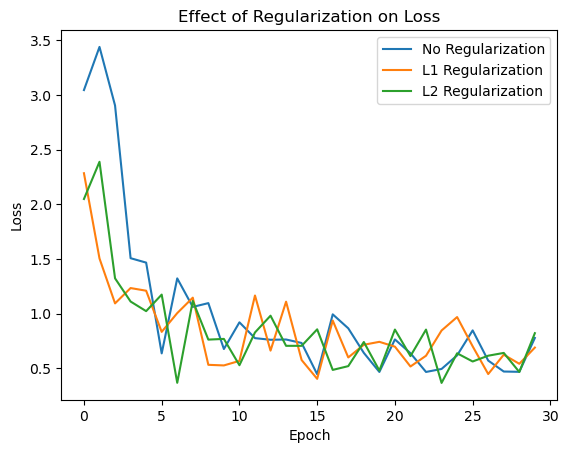

In [337]:
twoLayersMLPNone = MLP(lr = 0.005, nodes = [784, 128, 128, 10], beta_momentum = 0.9, initialWeightStrategy = NormalWeights(), activation = ReLUActivation(), batchsize = 64)
twoLayersMLPL1 = MLP(lr = 0.005, nodes = [784, 128, 128, 10], beta_momentum = 0.9, initialWeightStrategy = NormalWeights(), activation = ReLUActivation(), batchsize = 64, regularization = l1Regular(1e-4))
twoLayersMLPL2 = MLP(lr = 0.005, nodes = [784, 128, 128, 10], beta_momentum = 0.9, initialWeightStrategy = NormalWeights(), activation = ReLUActivation(), batchsize = 64, regularization = l2Regular(1e-4))

models = [twoLayersMLPNone, twoLayersMLPL1, twoLayersMLPL2]
names = ["No Regularization", "L1 Regularization", "L2 Regularization"]

for model, name in zip(models, names):
    model.fit(x_train_fash, y_train_fash, epochs=30, verbose=True)
    yhat = np.argmax(model.predict(x_test_fash), axis=1)
    yraw = np.argmax(y_test_fash, axis=1)
    model_accuracy = accuracy(yraw, yhat)
    print(f"Accuracy of {name} on TEST data is {model_accuracy}")
    plt.plot(model.epoch_history, model.cost_history, label=name)
plt.title("Effect of Regularization on Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#   plt.savefig('regularization_plot.png', bbox_inches='tight')
plt.show()

### 5. UnNormalized Data

In [338]:
#Have unormalized x data
x_train_fash_un = training_data.data
x_train_fash_un = np.array(x_train_fash_un)
x_train_fash_un = x_train_fash_un.reshape(-1, 784)

x_test_fash_un = test_data.data
x_test_fash_un = np.array(x_test_fash_un)
x_test_fash_un = x_test_fash_un.reshape(-1, 784)

Epoch : 1 | Loss : 3.0581134829194356
Epoch : 2 | Loss : 2.878231485551004
Epoch : 3 | Loss : 3.0581134829194356
Epoch : 4 | Loss : 2.338555016361921
Epoch : 5 | Loss : 3.238003099558814
Epoch : 6 | Loss : 3.4178927161981925
Epoch : 7 | Loss : 1.7988861664437856
Epoch : 8 | Loss : 3.965527846552301
Epoch : 9 | Loss : 1.9787757830831638
Epoch : 10 | Loss : 2.8782238662800568
Epoch : 11 | Loss : 2.8782238662800568
Epoch : 12 | Loss : 3.776834923922218
Epoch : 13 | Loss : 3.2380030995588145
Epoch : 14 | Loss : 2.5184211187978893
Epoch : 15 | Loss : 3.7776005036125087
Epoch : 16 | Loss : 3.2380013024347454
Epoch : 17 | Loss : 2.8910770964621513
Epoch : 18 | Loss : 4.62857290288064
Epoch : 19 | Loss : 3.565512588339177
Epoch : 20 | Loss : 3.0581134829194485
Epoch : 21 | Loss : 2.6983342496406624
Epoch : 22 | Loss : 3.238002680415959
Epoch : 23 | Loss : 3.7089192138816873
Epoch : 24 | Loss : 3.776641403044989
Epoch : 25 | Loss : 3.7776715740713978
Epoch : 26 | Loss : 3.417867478147894
Epoch 

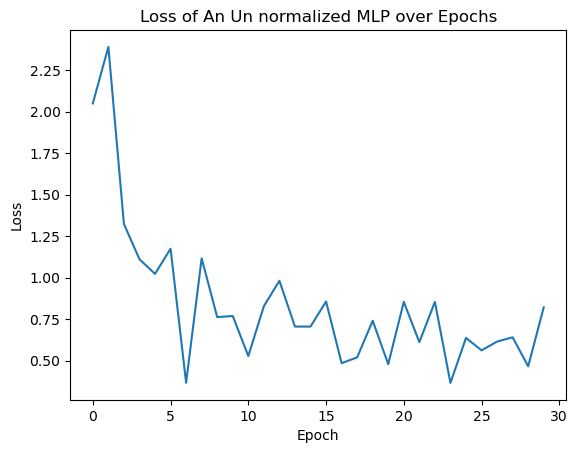

In [339]:
twoLayersUnnormalizedMLP = MLP(lr = 0.00001, nodes = [784, 128, 128, 10], beta_momentum = 0.9, initialWeightStrategy = NormalWeights(), activation = ReLUActivation(), batchsize = 64)
twoLayersUnnormalizedMLP.fit(x_train_fash_un, y_train_fash, verbose=True, epochs=30)
yhat = np.argmax(twoLayersUnnormalizedMLP.predict(x_test_fash_un), axis=1)
accuracyUnnormalized = accuracy(yhat, np.argmax(y_test_fash,axis=1))
print(f"Accuracy of Two Layer Model on Un normalized TEST data is {accuracyUnnormalized}")

plt.plot(model.epoch_history, model.cost_history)
plt.title("Loss of An Un normalized MLP over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.savefig('unnormalizedMLP.png', bbox_inches='tight')
plt.show()

It is really hard to do training without overflowing. If we increase learning rate then we quickly overflow.

### 6. PYTORCH CNN Effect of CNN?

Use GPU if avaliable and make some important utitlity functions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Functions for training the model and for evaluating the accuracy

In [8]:
def train_Model(optimizer, criterion, model, train_dataloader=train_dataloader, epochs=10):
    losses = []
    for epoch in range(epochs):
        epoch_loss = []
        # Iterate over data
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            # Move to GPU (if possible)
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients!
            optimizer.zero_grad()

            # Forward + loss calc + backward + step
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
        losses.append(np.mean(epoch_loss))
    return losses

In [9]:
def plotTrainingCurve(losses, saveImage=False, title="Epoch vs Loss"):
    plt.plot(np.arange(len(losses)), losses, 'r')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if(saveImage):
        plt.savefig(title + '.png', bbox_inches='tight')

In [10]:
def evaluateModelAccuracy(model, test_dataloader=test_dataloader, train_dataloader=None):
    if train_dataloader is not None:
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in train_dataloader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, dim=1)

                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        print(f"Train Accuracy: {(100 * correct / total)} %%")

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {(100 * correct / total)} %%")

First test, specifically only allowing 128 weights.

In [345]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=2, stride=2), #28 x 28 ->
            nn.ReLU(),
            nn.Conv2d(in_channels=2, out_channels=2, kernel_size=7),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128,128), #Big restriction here on 128
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.layers(x)

In [346]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [348]:
losses = train_Model(optimizer=optimizer, criterion=criterion, model=model, epochs=30)

Epoch: 1, Loss: 0.1499
Epoch: 2, Loss: 0.2855
Epoch: 3, Loss: 0.2534
Epoch: 4, Loss: 0.5218
Epoch: 5, Loss: 0.1158
Epoch: 6, Loss: 0.2103
Epoch: 7, Loss: 0.4373
Epoch: 8, Loss: 0.1590
Epoch: 9, Loss: 0.3975
Epoch: 10, Loss: 0.2638
Epoch: 11, Loss: 0.5008
Epoch: 12, Loss: 0.1722
Epoch: 13, Loss: 0.2966
Epoch: 14, Loss: 0.3111
Epoch: 15, Loss: 0.4618
Epoch: 16, Loss: 0.3804
Epoch: 17, Loss: 0.2046
Epoch: 18, Loss: 0.2369
Epoch: 19, Loss: 0.0518
Epoch: 20, Loss: 0.4854
Epoch: 21, Loss: 0.3441
Epoch: 22, Loss: 0.2598
Epoch: 23, Loss: 0.2710
Epoch: 24, Loss: 0.4965
Epoch: 25, Loss: 0.2493
Epoch: 26, Loss: 0.3675
Epoch: 27, Loss: 0.2177
Epoch: 28, Loss: 0.2431
Epoch: 29, Loss: 0.1691
Epoch: 30, Loss: 0.2677


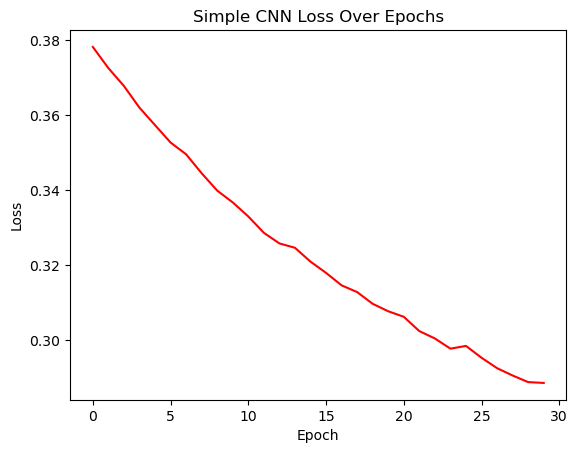

In [351]:
plotTrainingCurve(losses, title="Simple CNN Loss Over Epochs", saveImage=False)

In [352]:
evaluateModelAccuracy(model=model, test_dataloader=test_dataloader)

Test Accuracy: 87.38 %%


Creativity Points! Let's add a lot more features, use batch norm, and pooling to try to get a high performance.

In [363]:
class FancyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=32*6*6, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [364]:
model = FancyCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [371]:
losses = train_Model(optimizer=optimizer, criterion=criterion, model=model, epochs=30)

Epoch: 1, Loss: 0.0410
Epoch: 2, Loss: 0.1565
Epoch: 3, Loss: 0.1358
Epoch: 4, Loss: 0.0741
Epoch: 5, Loss: 0.1047
Epoch: 6, Loss: 0.2834
Epoch: 7, Loss: 0.1048
Epoch: 8, Loss: 0.1934
Epoch: 9, Loss: 0.1963
Epoch: 10, Loss: 0.1235
Epoch: 11, Loss: 0.0645
Epoch: 12, Loss: 0.0190
Epoch: 13, Loss: 0.2298
Epoch: 14, Loss: 0.1341
Epoch: 15, Loss: 0.0277
Epoch: 16, Loss: 0.1262
Epoch: 17, Loss: 0.1399
Epoch: 18, Loss: 0.1651
Epoch: 19, Loss: 0.0534
Epoch: 20, Loss: 0.1368
Epoch: 21, Loss: 0.1293
Epoch: 22, Loss: 0.2947
Epoch: 23, Loss: 0.0544
Epoch: 24, Loss: 0.0855
Epoch: 25, Loss: 0.0960
Epoch: 26, Loss: 0.0350
Epoch: 27, Loss: 0.1053
Epoch: 28, Loss: 0.2146
Epoch: 29, Loss: 0.1691
Epoch: 30, Loss: 0.0556


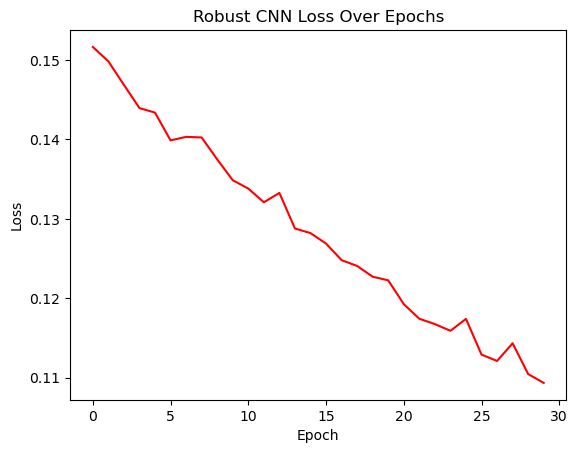

In [372]:
plotTrainingCurve(losses, title="Robust CNN Loss Over Epochs", saveImage=True)

In [373]:
evaluateModelAccuracy(model=model, test_dataloader=test_dataloader)

Test Accuracy: 90.29 %%


Our more Robust CNN was able to break 0.1 loss, and achieve a 90% score on test data.

### 7. MLP with CIFAR - Compare with CNN

Load CIFAR10

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Normalize data
train_cifar = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_cifar = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)
#Classes from the internet
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [396]:
np.unique(train_cifar.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000],
       dtype=int64))

In [397]:
np.unique(test_cifar.targets, return_counts=True)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       dtype=int64))

Again, even distributions.

In [377]:
#Create training set for x and ys
x_train_cifar, y_train_cifar = train_cifar.data, train_cifar.targets
y_train_cifar =  one_hot_encoding(np.array(y_train_cifar))
y_train_cifar = y_train_cifar.reshape(-1, 10)

x_train_cifar = np.array(x_train_cifar)
x_train_cifar = x_train_cifar.astype('float64')/255
x_train_cifar = x_train_cifar.reshape(-1, 32*32*3)




In [378]:
#Create testing set for x and ys
x_test_cifar, y_test_cifar = test_cifar.data, test_cifar.targets
y_test_cifar = np.array(y_test_cifar)
x_test_cifar = np.array(x_test_cifar)
x_test_cifar = x_test_cifar.reshape(-1, 32*32*3)
x_test_cifar = (x_test_cifar/255).astype('float64')

y_test_cifar = y_test_cifar.reshape(1, -1)
y_test_cifar = one_hot_encoding(y_test_cifar)
y_test_cifar = y_test_cifar.reshape(-1, 10)

TESTING OUR MLP ON CIFAR10

In [381]:
MLP_cifar = MLP(lr = 0.05, nodes = [32*32*3, 1024, 512, 10], beta_momentum = 0.9, initialWeightStrategy = KaimingWeights(), activation = ReLUActivation(), batchsize = 64)
MLP_cifar.fit(x_train_cifar, y_train_cifar, verbose=True, epochs=20)

Epoch : 1 | Loss : 2.2997300499724935
Epoch : 2 | Loss : 2.0684978224694923
Epoch : 3 | Loss : 1.9554500873132301
Epoch : 4 | Loss : 1.75632290922277
Epoch : 5 | Loss : 1.5996889315294087
Epoch : 6 | Loss : 1.5171639307861888
Epoch : 7 | Loss : 1.6103262214196299
Epoch : 8 | Loss : 1.7357764370978144
Epoch : 9 | Loss : 1.4295019249605327
Epoch : 10 | Loss : 1.7721004301640044
Epoch : 11 | Loss : 1.4637103854744589
Epoch : 12 | Loss : 1.2437487347658909
Epoch : 13 | Loss : 1.1731986377740098
Epoch : 14 | Loss : 1.1617426401811048
Epoch : 15 | Loss : 1.4138221123891692
Epoch : 16 | Loss : 1.1641052363539042
Epoch : 17 | Loss : 1.1549642749225102
Epoch : 18 | Loss : 1.659538124750417
Epoch : 19 | Loss : 1.1904610300966905
Epoch : 20 | Loss : 1.0963432080440454


0.504


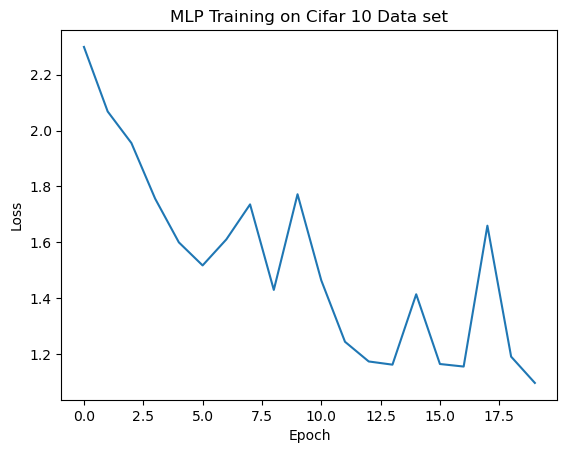

In [402]:
yhat = np.argmax(MLP_cifar.predict(x_test_cifar), axis=1)
print(accuracy(yhat, np.argmax(y_test_cifar,axis=1)))


plt.plot(MLP_cifar.epoch_history, MLP_cifar.cost_history)
plt.title("MLP Training on Cifar 10 Data set")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.savefig('MLP_CIFAR.png', bbox_inches='tight')
plt.show()

Testing a CNN model with Cifar

In [398]:
trainloader_cifar = DataLoader(train_cifar, batch_size=64,
                                                shuffle=True)
testloader_cifar = DataLoader(test_cifar, batch_size=64,
                                               shuffle=False,)

In [ ]:
#Use simple and robust CNN with Cifar10

In [454]:
class SimpleCIFARCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=2, stride=2), #32 x 32 ->
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=2, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2 * 8 * 8 ,128), #Allowed input dimension to be different than 128
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,10)
        )
    def forward(self, x):
        return self.layers(x)

In [455]:
model = SimpleCIFARCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [456]:
losses =train_Model(optimizer=optimizer, criterion=criterion, model=model, train_dataloader= trainloader_cifar, epochs=30)

Epoch: 1, Loss: 2.2982
Epoch: 2, Loss: 2.3317
Epoch: 3, Loss: 2.0371
Epoch: 4, Loss: 1.9105
Epoch: 5, Loss: 2.0250
Epoch: 6, Loss: 1.7068
Epoch: 7, Loss: 1.8651
Epoch: 8, Loss: 1.7563
Epoch: 9, Loss: 1.5865
Epoch: 10, Loss: 1.8200
Epoch: 11, Loss: 1.5342
Epoch: 12, Loss: 1.8118
Epoch: 13, Loss: 1.1902
Epoch: 14, Loss: 1.9285
Epoch: 15, Loss: 1.6182
Epoch: 16, Loss: 1.5257
Epoch: 17, Loss: 1.9198
Epoch: 18, Loss: 1.5874
Epoch: 19, Loss: 1.4422
Epoch: 20, Loss: 1.3240
Epoch: 21, Loss: 1.5980
Epoch: 22, Loss: 1.4476
Epoch: 23, Loss: 1.7637
Epoch: 24, Loss: 1.6627
Epoch: 25, Loss: 1.2761
Epoch: 26, Loss: 1.7572
Epoch: 27, Loss: 1.4834
Epoch: 28, Loss: 1.6468
Epoch: 29, Loss: 1.6822
Epoch: 30, Loss: 1.7289


In [457]:
evaluateModelAccuracy(model=model, test_dataloader=testloader_cifar)

Test Accuracy: 44.49 %%


### 8. Optimizer performance on CNN

We wanted to use a more robust CNN model for this. Using techniques talked about in class.

In [443]:
class RobustCIFARCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3), #32 x 32 ->
            nn.ReLU(),
            nn.MaxPool2d(2), #15
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2), #7
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm2d(64), #6
            nn.Flatten(),
            nn.Linear(64 * 6 * 6 ,1024), #Allowed input dimension to be different than 128
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        return self.layers(x)

In [444]:
model = RobustCIFARCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [445]:
train_Model(model=model, criterion=criterion, optimizer=optimizer, train_dataloader=trainloader_cifar)


Epoch: 1, Loss: 1.8518
Epoch: 2, Loss: 1.0935
Epoch: 3, Loss: 0.5789
Epoch: 4, Loss: 1.1720
Epoch: 5, Loss: 0.8534
Epoch: 6, Loss: 0.8108
Epoch: 7, Loss: 0.5296
Epoch: 8, Loss: 0.1804
Epoch: 9, Loss: 0.5848
Epoch: 10, Loss: 0.6948


[1.7145777910261812,
 1.2139649616025598,
 1.015899809196477,
 0.883257892544922,
 0.7805277813044961,
 0.6887868142036526,
 0.6031301993009685,
 0.5235870139830557,
 0.43949323198984347,
 0.36627906886741635]

In [446]:
evaluateModelAccuracy(model=model, test_dataloader=testloader_cifar)

Test Accuracy: 73.35 %%


In [467]:
momentum_values = [0, 0.5, 0.9, 0.99]

SGD

Epoch: 1, Loss: 2.2853
Epoch: 2, Loss: 2.3116
Epoch: 3, Loss: 2.3042
Epoch: 4, Loss: 2.2939
Epoch: 5, Loss: 2.3001
Epoch: 6, Loss: 2.2948
Epoch: 7, Loss: 2.2968
Epoch: 8, Loss: 2.2999
Epoch: 9, Loss: 2.2900
Epoch: 10, Loss: 2.2875
Epoch: 11, Loss: 2.2106
Epoch: 12, Loss: 2.2561
Epoch: 13, Loss: 2.2361
Epoch: 14, Loss: 2.1758
Epoch: 15, Loss: 2.3316
Epoch: 16, Loss: 1.9774
Epoch: 17, Loss: 1.9895
Epoch: 18, Loss: 1.8522
Epoch: 19, Loss: 2.0277
Epoch: 20, Loss: 2.1328
Test Accuracy: 27.32 %%
Epoch: 1, Loss: 2.2971
Epoch: 2, Loss: 2.2917
Epoch: 3, Loss: 2.3204
Epoch: 4, Loss: 2.3002
Epoch: 5, Loss: 2.3079
Epoch: 6, Loss: 2.2962
Epoch: 7, Loss: 2.3019
Epoch: 8, Loss: 2.2943
Epoch: 9, Loss: 2.2908
Epoch: 10, Loss: 2.2981
Epoch: 11, Loss: 2.2749
Epoch: 12, Loss: 2.3011
Epoch: 13, Loss: 2.2832
Epoch: 14, Loss: 2.1701
Epoch: 15, Loss: 2.3121
Epoch: 16, Loss: 2.2948
Epoch: 17, Loss: 2.1145
Epoch: 18, Loss: 2.1813
Epoch: 19, Loss: 1.9558
Epoch: 20, Loss: 2.0331
Test Accuracy: 27.68 %%
Epoch: 1, 

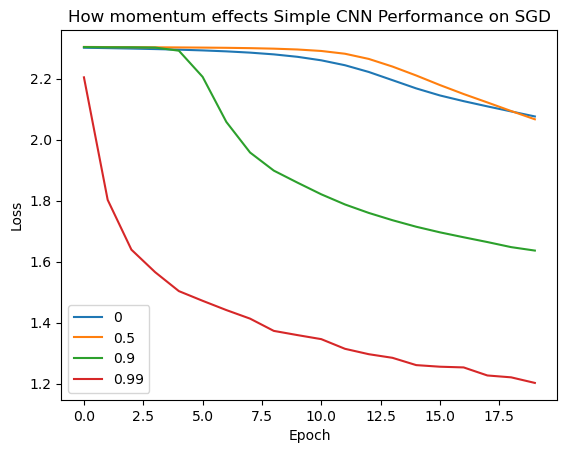

In [470]:
#Simple CNN
for momentum_val in momentum_values:
    model = SimpleCIFARCNN()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=momentum_val)
    losses = train_Model(optimizer=optimizer, criterion=criterion, model=model, train_dataloader= trainloader_cifar, epochs=20)
    plt.plot(np.arange(len(losses)), losses, label=momentum_val)
    evaluateModelAccuracy(model=model, test_dataloader=testloader_cifar)
plt.title("How momentum effects Simple CNN Performance on SGD")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('Momentum_SGD_Simple.png', bbox_inches='tight')
plt.show()

Epoch: 1, Loss: 2.2042
Epoch: 2, Loss: 2.0716
Epoch: 3, Loss: 2.1308
Epoch: 4, Loss: 1.8296
Epoch: 5, Loss: 1.4780
Epoch: 6, Loss: 1.8185
Epoch: 7, Loss: 1.6774
Epoch: 8, Loss: 1.2242
Epoch: 9, Loss: 1.3765
Epoch: 10, Loss: 1.3186
Epoch: 11, Loss: 1.1974
Epoch: 12, Loss: 1.0769
Epoch: 13, Loss: 1.1391
Epoch: 14, Loss: 1.9752
Epoch: 15, Loss: 1.3387
Epoch: 16, Loss: 1.3557
Epoch: 17, Loss: 1.3433
Epoch: 18, Loss: 1.1113
Epoch: 19, Loss: 1.1437
Epoch: 20, Loss: 1.4144
Test Accuracy: 62.65 %%
Epoch: 1, Loss: 1.8755
Epoch: 2, Loss: 1.8235
Epoch: 3, Loss: 1.2462
Epoch: 4, Loss: 1.6564
Epoch: 5, Loss: 1.1216
Epoch: 6, Loss: 1.4902
Epoch: 7, Loss: 1.0857
Epoch: 8, Loss: 1.5649
Epoch: 9, Loss: 1.6088
Epoch: 10, Loss: 1.0434
Epoch: 11, Loss: 0.7151
Epoch: 12, Loss: 0.6459
Epoch: 13, Loss: 1.0248
Epoch: 14, Loss: 0.9171
Epoch: 15, Loss: 0.4814
Epoch: 16, Loss: 0.8956
Epoch: 17, Loss: 1.1997
Epoch: 18, Loss: 0.7176
Epoch: 19, Loss: 0.4499
Epoch: 20, Loss: 0.9209
Test Accuracy: 70.18 %%
Epoch: 1, 

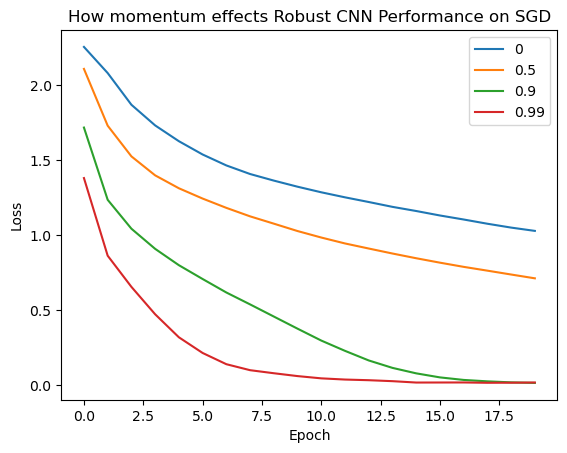

In [471]:
#Robust CNN
for momentum_val in momentum_values:
    model = RobustCIFARCNN()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=momentum_val)
    losses = train_Model(optimizer=optimizer, criterion=criterion, model=model, train_dataloader= trainloader_cifar, epochs=20)
    plt.plot(np.arange(len(losses)), losses, label=momentum_val)
    evaluateModelAccuracy(model=model, test_dataloader=testloader_cifar)
plt.title("How momentum effects Robust CNN Performance on SGD")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('Momentum_SGD_Robust.png', bbox_inches='tight')
plt.show()

Adam

Epoch: 1, Loss: 2.0101
Epoch: 2, Loss: 1.5745
Epoch: 3, Loss: 2.0668
Epoch: 4, Loss: 1.5327
Epoch: 5, Loss: 1.3868
Epoch: 6, Loss: 1.6420
Epoch: 7, Loss: 1.2272
Epoch: 8, Loss: 1.5649
Epoch: 9, Loss: 1.2985
Epoch: 10, Loss: 1.3498
Epoch: 11, Loss: 0.9136
Epoch: 12, Loss: 1.9755
Epoch: 13, Loss: 1.4977
Epoch: 14, Loss: 1.7421
Epoch: 15, Loss: 1.3206
Epoch: 16, Loss: 1.3792
Epoch: 17, Loss: 1.0405
Epoch: 18, Loss: 1.0855
Epoch: 19, Loss: 1.2759
Epoch: 20, Loss: 1.6083
Test Accuracy: 51.41 %%


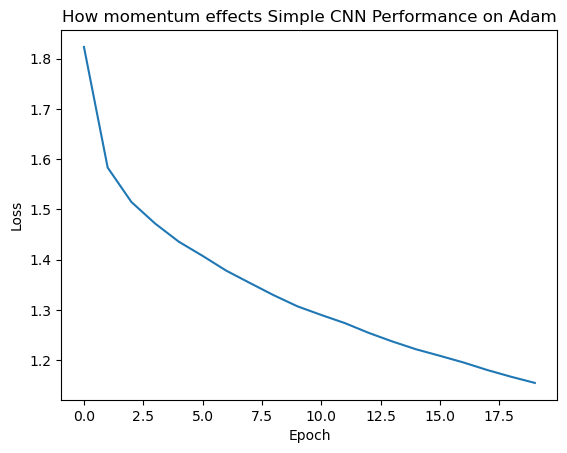

In [474]:
#Simple CNN
model = SimpleCIFARCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = train_Model(optimizer=optimizer, criterion=criterion, model=model, train_dataloader= trainloader_cifar, epochs=20)
plt.plot(np.arange(len(losses)), losses)
evaluateModelAccuracy(model=model, test_dataloader=testloader_cifar)
plt.title("How momentum effects Simple CNN Performance on Adam")
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('Momentum_Adam_Simple.png', bbox_inches='tight')
plt.show()

Epoch: 1, Loss: 1.1131
Epoch: 2, Loss: 0.7908
Epoch: 3, Loss: 0.3225
Epoch: 4, Loss: 0.7455
Epoch: 5, Loss: 0.0875
Epoch: 6, Loss: 0.0725
Epoch: 7, Loss: 0.1041
Epoch: 8, Loss: 0.1395
Epoch: 9, Loss: 0.0081
Epoch: 10, Loss: 0.6880
Epoch: 11, Loss: 0.0006
Epoch: 12, Loss: 0.0247
Epoch: 13, Loss: 0.0091
Epoch: 14, Loss: 0.0113
Epoch: 15, Loss: 0.0736
Epoch: 16, Loss: 0.3261
Epoch: 17, Loss: 0.5835
Epoch: 18, Loss: 0.1931
Epoch: 19, Loss: 0.0258
Epoch: 20, Loss: 0.0107
Test Accuracy: 72.98 %%


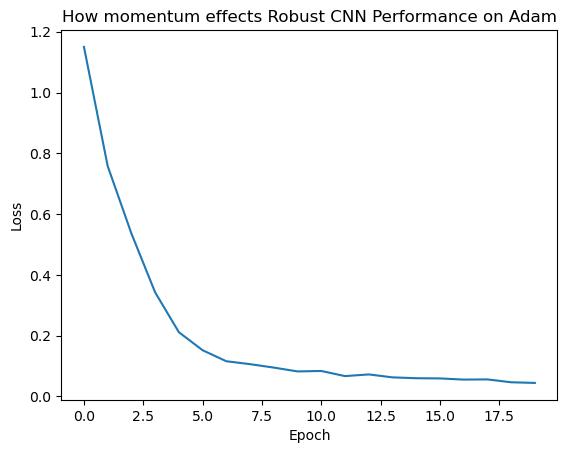

In [476]:
#Robust CNN
model = RobustCIFARCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = train_Model(optimizer=optimizer, criterion=criterion, model=model, train_dataloader= trainloader_cifar, epochs=20)
plt.plot(np.arange(len(losses)), losses)
evaluateModelAccuracy(model=model, test_dataloader=testloader_cifar)
plt.title("How momentum effects Robust CNN Performance on Adam")
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('Momentum_Adam_Robust.png', bbox_inches='tight')
plt.show()

### 9. Pre-trained Model

Let's load the pretrained restnet 50 model.

In [12]:
transform = transforms.Compose(
    [
     transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_cifar_large = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_cifar_large = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)

trainloader_cifar_large = DataLoader(train_cifar_large, batch_size=64,
                               shuffle=True)
testloader_cifar_large = DataLoader(test_cifar_large, batch_size=64,
                              shuffle=False,)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
from torchvision import models
import torchvision

In [ ]:
default_weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet = models.resnet50(weights = default_weights) ###Resnet has an 1000 label output.
for param in resnet.parameters():
    param.requires_grad = False

infeat = resnet.fc.in_features
resnet.fc = torch.nn.Sequential(
    nn.Linear(infeat, infeat),
    nn.ReLU(),
    nn.Linear(infeat, 10)
)


In [15]:
for name,param in resnet.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

	 fc.0.weight
	 fc.0.bias
	 fc.2.weight
	 fc.2.bias


In [16]:
for n, m in resnet.named_parameters():
    print(n)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [19]:
i=1
for n, m in resnet.named_parameters():
    i+=1
print(i)

164


In [11]:
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=1e-3, momentum=0.9)

In [27]:
losses = train_Model(model=resnet, criterion=criterion, optimizer=optimizer, train_dataloader=trainloader_cifar_large, epochs=10)

Epoch: 1, Loss: 1.0199
Epoch: 2, Loss: 1.1489
Epoch: 3, Loss: 0.5269
Epoch: 4, Loss: 1.0104
Epoch: 5, Loss: 0.2224
Epoch: 6, Loss: 0.6421
Epoch: 7, Loss: 0.4984
Epoch: 8, Loss: 0.7799
Epoch: 9, Loss: 0.5112
Epoch: 10, Loss: 1.2313


In [28]:
evaluateModelAccuracy(model=resnet, test_dataloader=testloader_cifar_large)

Test Accuracy: 80.18 %%


Effect of Strength of Regularization on our MLP

In [477]:
regularization_values = [0, 0.1, 0.01, 0.001, 0.0001]

Epoch : 1 | Loss : 2.2974313836313875
Epoch : 2 | Loss : 2.2220483705817413
Epoch : 3 | Loss : 1.4301575537116118
Epoch : 4 | Loss : 1.050527966138603
Epoch : 5 | Loss : 0.9184695240077266
Epoch : 6 | Loss : 0.9345092775832169
Epoch : 7 | Loss : 0.7050915644643649
Epoch : 8 | Loss : 0.7210081626462674
Epoch : 9 | Loss : 0.6199432338199546
Epoch : 10 | Loss : 0.7014836169652381
Epoch : 11 | Loss : 0.5196755708278171
Epoch : 12 | Loss : 0.5452555485526489
Epoch : 13 | Loss : 0.7199814934718238
Epoch : 14 | Loss : 0.6603488891474598
Epoch : 15 | Loss : 0.5038091468970107
Epoch : 16 | Loss : 0.40640840762305874
Epoch : 17 | Loss : 0.4933905706500318
Epoch : 18 | Loss : 0.4867913034223451
Epoch : 19 | Loss : 0.45119398618738016
Epoch : 20 | Loss : 0.5869290637383858
Epoch : 21 | Loss : 0.4160550380135351
Epoch : 22 | Loss : 0.5098271073522622
Epoch : 23 | Loss : 0.45914838604210073
Epoch : 24 | Loss : 0.4867587256469953
Epoch : 25 | Loss : 0.30834598429671856
Epoch : 26 | Loss : 0.477881280

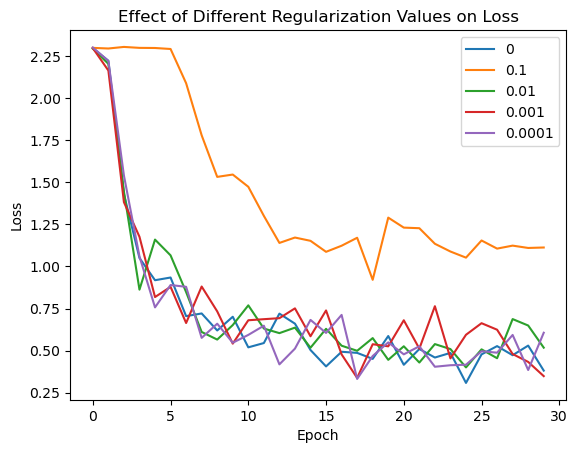

In [481]:
for value in regularization_values:
    model = MLP(lr = 0.005, nodes = [784, 128, 128, 10], beta_momentum = 0.99, initialWeightStrategy = KaimingWeights(), activation = ReLUActivation(), batchsize = 64, regularization = l2Regular(value))
    model.fit(x_train_fash, y_train_fash, epochs=30, verbose=True)
    yhat = np.argmax(model.predict(x_test_fash), axis=1)
    yraw = np.argmax(y_test_fash, axis=1)
    model_accuracy = accuracy(yraw, yhat)
    print(f"Accuracy of {value} regularization on TEST data is {model_accuracy}")
    plt.plot(model.epoch_history, model.cost_history, label=value)
plt.title("Effect of Different Regularization Values on Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('regularization_differences_plot.png', bbox_inches='tight')
plt.show()

Epoch : 1 | Loss : 2.302487679938383
Epoch : 2 | Loss : 2.3015426449531096
Epoch : 3 | Loss : 2.2984372036553973
Epoch : 4 | Loss : 2.2933534794042743
Epoch : 5 | Loss : 2.289252558791495
Epoch : 6 | Loss : 2.2761539285509835
Epoch : 7 | Loss : 2.257606940243631
Epoch : 8 | Loss : 2.1908471318168408
Epoch : 9 | Loss : 2.0295133591558856
Epoch : 10 | Loss : 1.7218119222140644
Epoch : 11 | Loss : 1.6033125794054013
Epoch : 12 | Loss : 1.401047447205828
Epoch : 13 | Loss : 1.216001677040225
Epoch : 14 | Loss : 1.1333990205792916
Epoch : 15 | Loss : 1.0256210038604419
Epoch : 16 | Loss : 0.9080622928317512
Epoch : 17 | Loss : 0.8757465684016881
Epoch : 18 | Loss : 1.0333592916135692
Epoch : 19 | Loss : 0.8095777259725822
Epoch : 20 | Loss : 0.977380654216995
Epoch : 21 | Loss : 0.7760525241173066
Epoch : 22 | Loss : 0.8642991731342142
Epoch : 23 | Loss : 0.8089135340237618
Epoch : 24 | Loss : 0.7400188323664105
Epoch : 25 | Loss : 1.0157189034383443
Epoch : 26 | Loss : 0.7511538260583119
E

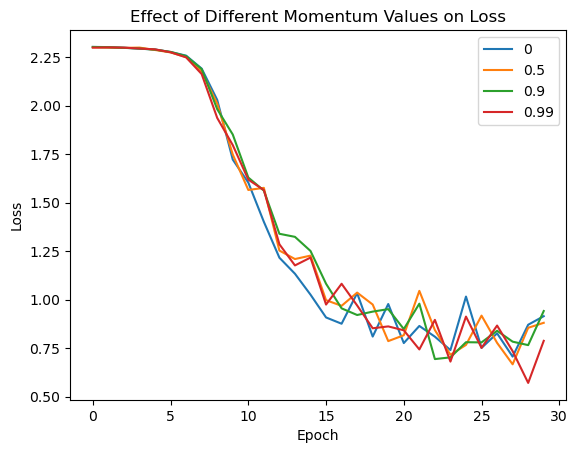

In [483]:
for value in momentum_values:
    model = MLP(lr = 0.001, nodes = [784, 128, 128, 10], beta_momentum = value, initialWeightStrategy = KaimingWeights(), activation = ReLUActivation(), batchsize = 64)
    model.fit(x_train_fash, y_train_fash, epochs=30, verbose=True)
    yhat = np.argmax(model.predict(x_test_fash), axis=1)
    yraw = np.argmax(y_test_fash, axis=1)
    model_accuracy = accuracy(yraw, yhat)
    print(f"Accuracy of {value} momentum on TEST data is {model_accuracy}")
    plt.plot(model.epoch_history, model.cost_history, label=value)
plt.title("Effect of Different Momentum Values on Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('momentum_differences_plot.png', bbox_inches='tight')
plt.show()

In [ ]:
#Seems momentum does not have a big effect on FashionMNIST as we converge quickly either way.